In [1]:
import pandas as pd
import re
import matplotlib as plt
import numpy as np
from datetime import *
import graphviz

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# Read the dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Merge dataset : Train + Test // drop unnecessary features
dataset = train.drop(['AnimalID', 'OutcomeSubtype', 'OutcomeType', 'DateTime'], axis=1)
dataset = dataset.append(test.drop(['ID', 'DateTime'], axis=1), ignore_index=True)
print(train.shape, test.shape, dataset.shape)

(26729, 10) (11456, 8) (38185, 6)


In [3]:
dataset.tail()

,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
38180,NaN,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black
38181,NaN,Cat,Intact Female,2 weeks,Domestic Shorthair Mix,Blue
38182,NaN,Cat,Intact Female,1 year,Domestic Shorthair Mix,Calico
38183,Rambo,Dog,Neutered Male,6 years,German Shepherd Mix,Black/Tan
38184,Gusto,Dog,Intact Male,4 years,Labrador Retriever,Cream


In [4]:
dataset.isnull().sum()

Name              10916
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       24
Breed                 0
Color                 0
dtype: int64

In [5]:
#calculate Age in days
def calculate_age(x):
    if pd.isnull(x):
        return x
    num = int(x.split(' ')[0])
    if 'year' in x:
        return num * 365
    elif 'month' in x:
        return num * 30
    elif 'week' in x:
        return num * 7
    
def has_name(x):
    if pd.isnull(x):
        return 0
    return 1

def is_mix(x):
    if 'Mix' in x:
        return 1
    return 0

In [6]:
#data transformation

dataset['AgeuponOutcome'] = dataset['AgeuponOutcome'].apply(lambda x : calculate_age(x))
dataset['AgeuponOutcome'].fillna(dataset['AgeuponOutcome'].dropna().mean(), inplace=True)

dataset.tail()

,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
38180,NaN,Cat,Neutered Male,60.0,Domestic Shorthair Mix,Black
38181,NaN,Cat,Intact Female,14.0,Domestic Shorthair Mix,Blue
38182,NaN,Cat,Intact Female,365.0,Domestic Shorthair Mix,Calico
38183,Rambo,Dog,Neutered Male,2190.0,German Shepherd Mix,Black/Tan
38184,Gusto,Dog,Intact Male,1460.0,Labrador Retriever,Cream


In [7]:
# Since there is only one NA, I will assign it to maximum class
dataset['SexuponOutcome'].fillna('Neutered Male', inplace=True)

dataset.tail()

,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
38180,NaN,Cat,Neutered Male,60.0,Domestic Shorthair Mix,Black
38181,NaN,Cat,Intact Female,14.0,Domestic Shorthair Mix,Blue
38182,NaN,Cat,Intact Female,365.0,Domestic Shorthair Mix,Calico
38183,Rambo,Dog,Neutered Male,2190.0,German Shepherd Mix,Black/Tan
38184,Gusto,Dog,Intact Male,1460.0,Labrador Retriever,Cream


In [8]:
# Does Animal has a name
dataset['HasName'] = dataset['Name'].apply(has_name)

dataset.tail()

,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,HasName
38180,NaN,Cat,Neutered Male,60.0,Domestic Shorthair Mix,Black,0
38181,NaN,Cat,Intact Female,14.0,Domestic Shorthair Mix,Blue,0
38182,NaN,Cat,Intact Female,365.0,Domestic Shorthair Mix,Calico,0
38183,Rambo,Dog,Neutered Male,2190.0,German Shepherd Mix,Black/Tan,1
38184,Gusto,Dog,Intact Male,1460.0,Labrador Retriever,Cream,1


In [9]:
# Is animal of mix breed?
dataset['IsMix'] = dataset['Breed'].apply(is_mix)

dataset.tail()

,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,HasName,IsMix
38180,NaN,Cat,Neutered Male,60.0,Domestic Shorthair Mix,Black,0,1
38181,NaN,Cat,Intact Female,14.0,Domestic Shorthair Mix,Blue,0,1
38182,NaN,Cat,Intact Female,365.0,Domestic Shorthair Mix,Calico,0,1
38183,Rambo,Dog,Neutered Male,2190.0,German Shepherd Mix,Black/Tan,1,1
38184,Gusto,Dog,Intact Male,1460.0,Labrador Retriever,Cream,1,0


In [10]:
# Break SexuponOutcome into two - Sterilized and Sex
sex = dataset['SexuponOutcome'].str.split(' ', expand=True)
dataset['Sterilized'] = sex[0]
dataset['Sterilized'].fillna('Unknown', inplace=True)
dataset['Sex'] = sex[1]
dataset['Sex'].fillna('Unknown', inplace=True)

dataset.tail()

,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,HasName,IsMix,Sterilized,Sex
38180,NaN,Cat,Neutered Male,60.0,Domestic Shorthair Mix,Black,0,1,Neutered,Male
38181,NaN,Cat,Intact Female,14.0,Domestic Shorthair Mix,Blue,0,1,Intact,Female
38182,NaN,Cat,Intact Female,365.0,Domestic Shorthair Mix,Calico,0,1,Intact,Female
38183,Rambo,Dog,Neutered Male,2190.0,German Shepherd Mix,Black/Tan,1,1,Neutered,Male
38184,Gusto,Dog,Intact Male,1460.0,Labrador Retriever,Cream,1,0,Intact,Male


In [11]:
# Making cols about Breeds

dataset['Breed_New'] = dataset['Breed'].apply(lambda x: x.split(' Mix')[0])
breeds = dataset['Breed_New'].apply(lambda x : x.split('/'))
dataset['Breed_1'] = breeds.apply(lambda x : x[0])
# Instead of Breed_2, I will use Multiple_Breeds feature
#dataset['Breed_2'] = breeds.apply(lambda x : 'Unknown' if len(x) == 1 else x[1] )
dataset['Multiple_Breeds'] = dataset['Breed'].apply(lambda x : 1 if '/' in x else 0)

dataset.tail()

,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,HasName,IsMix,Sterilized,Sex,Breed_New,Breed_1,Multiple_Breeds
38180,NaN,Cat,Neutered Male,60.0,Domestic Shorthair Mix,Black,0,1,Neutered,Male,Domestic Shorthair,Domestic Shorthair,0
38181,NaN,Cat,Intact Female,14.0,Domestic Shorthair Mix,Blue,0,1,Intact,Female,Domestic Shorthair,Domestic Shorthair,0
38182,NaN,Cat,Intact Female,365.0,Domestic Shorthair Mix,Calico,0,1,Intact,Female,Domestic Shorthair,Domestic Shorthair,0
38183,Rambo,Dog,Neutered Male,2190.0,German Shepherd Mix,Black/Tan,1,1,Neutered,Male,German Shepherd,German Shepherd,0
38184,Gusto,Dog,Intact Male,1460.0,Labrador Retriever,Cream,1,0,Intact,Male,Labrador Retriever,Labrador Retriever,0


In [12]:
# Making cols about Colors

colors = dataset['Color'].apply(lambda x : x.split('/'))
dataset['Color_1'] = colors.apply(lambda x : x[0].split(' ')[0])
# Instead of Color_2, I will use Multiple_Colors feature
# dataset['Color_2'] = colors.apply(lambda x : x[1].split(' ')[0] if len(x) > 1 else 'None')
dataset['Multiple_Colors'] = dataset['Color'].apply(lambda x : 1 if '/' in x else 0)

dataset.tail()

,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,HasName,IsMix,Sterilized,Sex,Breed_New,Breed_1,Multiple_Breeds,Color_1,Multiple_Colors
38180,NaN,Cat,Neutered Male,60.0,Domestic Shorthair Mix,Black,0,1,Neutered,Male,Domestic Shorthair,Domestic Shorthair,0,Black,0
38181,NaN,Cat,Intact Female,14.0,Domestic Shorthair Mix,Blue,0,1,Intact,Female,Domestic Shorthair,Domestic Shorthair,0,Blue,0
38182,NaN,Cat,Intact Female,365.0,Domestic Shorthair Mix,Calico,0,1,Intact,Female,Domestic Shorthair,Domestic Shorthair,0,Calico,0
38183,Rambo,Dog,Neutered Male,2190.0,German Shepherd Mix,Black/Tan,1,1,Neutered,Male,German Shepherd,German Shepherd,0,Black,1
38184,Gusto,Dog,Intact Male,1460.0,Labrador Retriever,Cream,1,0,Intact,Male,Labrador Retriever,Labrador Retriever,0,Cream,0


In [13]:
# Encoding
enc = LabelEncoder()
dataset['Color_1'] = enc.fit_transform(dataset['Color_1'])
dataset['Breed_1'] = enc.fit_transform(dataset['Breed_1'])

dataset.tail()

,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,HasName,IsMix,Sterilized,Sex,Breed_New,Breed_1,Multiple_Breeds,Color_1,Multiple_Colors
38180,NaN,Cat,Neutered Male,60.0,Domestic Shorthair Mix,Black,0,1,Neutered,Male,Domestic Shorthair,85,0,2,0
38181,NaN,Cat,Intact Female,14.0,Domestic Shorthair Mix,Blue,0,1,Intact,Female,Domestic Shorthair,85,0,3,0
38182,NaN,Cat,Intact Female,365.0,Domestic Shorthair Mix,Calico,0,1,Intact,Female,Domestic Shorthair,85,0,6,0
38183,Rambo,Dog,Neutered Male,2190.0,German Shepherd Mix,Black/Tan,1,1,Neutered,Male,German Shepherd,104,0,2,1
38184,Gusto,Dog,Intact Male,1460.0,Labrador Retriever,Cream,1,0,Intact,Male,Labrador Retriever,131,0,8,0


In [14]:
# Dummy Columns
dummy_columns = ['Sterilized', 'Sex']
dataset = pd.get_dummies(dataset, columns=dummy_columns)

dataset.tail()

,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,HasName,IsMix,Breed_New,Breed_1,Multiple_Breeds,Color_1,Multiple_Colors,Sterilized_Intact,Sterilized_Neutered,Sterilized_Spayed,Sterilized_Unknown,Sex_Female,Sex_Male,Sex_Unknown
38180,NaN,Cat,Neutered Male,60.0,Domestic Shorthair Mix,Black,0,1,Domestic Shorthair,85,0,2,0,0,1,0,0,0,1,0
38181,NaN,Cat,Intact Female,14.0,Domestic Shorthair Mix,Blue,0,1,Domestic Shorthair,85,0,3,0,1,0,0,0,1,0,0
38182,NaN,Cat,Intact Female,365.0,Domestic Shorthair Mix,Calico,0,1,Domestic Shorthair,85,0,6,0,1,0,0,0,1,0,0
38183,Rambo,Dog,Neutered Male,2190.0,German Shepherd Mix,Black/Tan,1,1,German Shepherd,104,0,2,1,0,1,0,0,0,1,0
38184,Gusto,Dog,Intact Male,1460.0,Labrador Retriever,Cream,1,0,Labrador Retriever,131,0,8,0,1,0,0,0,0,1,0


In [15]:
# Drop unnecessary columns
drop_columns = ['Name', 'SexuponOutcome', 'Breed', 'Color', 'Breed_New', 'AnimalType']
dataset = dataset.drop(drop_columns, axis=1)

print(train.shape, test.shape, dataset.shape)

dataset.tail()

(26729, 10) (11456, 8) (38185, 14)


,AgeuponOutcome,HasName,IsMix,Breed_1,Multiple_Breeds,Color_1,Multiple_Colors,Sterilized_Intact,Sterilized_Neutered,Sterilized_Spayed,Sterilized_Unknown,Sex_Female,Sex_Male,Sex_Unknown
38180,60.0,0,1,85,0,2,0,0,1,0,0,0,1,0
38181,14.0,0,1,85,0,3,0,1,0,0,0,1,0,0
38182,365.0,0,1,85,0,6,0,1,0,0,0,1,0,0
38183,2190.0,1,1,104,0,2,1,0,1,0,0,0,1,0
38184,1460.0,1,0,131,0,8,0,1,0,0,0,0,1,0


In [16]:
# Split dataset to train_x, train_y and test_x

train_x = dataset.loc[0:26728,]

enc = LabelEncoder()
train_y = enc.fit_transform(train['OutcomeType'])
train_y = pd.DataFrame(train_y)

test_x = dataset.loc[26729:38185,]

In [17]:
train_x.tail()

,AgeuponOutcome,HasName,IsMix,Breed_1,Multiple_Breeds,Color_1,Multiple_Colors,Sterilized_Intact,Sterilized_Neutered,Sterilized_Spayed,Sterilized_Unknown,Sex_Female,Sex_Male,Sex_Unknown
26724,30.0,0,1,85,0,4,1,1,0,0,0,0,1,0
26725,90.0,0,1,85,0,4,0,0,0,1,0,1,0,0
26726,1460.0,1,1,155,0,27,1,0,1,0,0,0,1,0
26727,28.0,0,1,85,0,2,0,1,0,0,0,0,1,0
26728,365.0,0,1,85,0,4,1,1,0,0,0,0,1,0


In [18]:
train_y.tail()

,0
26724,4
26725,4
26726,0
26727,4
26728,4


In [19]:
test_x.tail()

,AgeuponOutcome,HasName,IsMix,Breed_1,Multiple_Breeds,Color_1,Multiple_Colors,Sterilized_Intact,Sterilized_Neutered,Sterilized_Spayed,Sterilized_Unknown,Sex_Female,Sex_Male,Sex_Unknown
38180,60.0,0,1,85,0,2,0,0,1,0,0,0,1,0
38181,14.0,0,1,85,0,3,0,1,0,0,0,1,0,0
38182,365.0,0,1,85,0,6,0,1,0,0,0,1,0,0
38183,2190.0,1,1,104,0,2,1,0,1,0,0,0,1,0
38184,1460.0,1,0,131,0,8,0,1,0,0,0,0,1,0


In [20]:
# Cross Validation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(train_x.values, train_y[0].values, test_size=0.3, random_state=0)

In [21]:
#Choose best parameters for randomforest
def best_params(train_x, train_y):
    rfc = RandomForestClassifier()
    param_grid = { 
        'n_estimators': [50, 400],
        'max_features': ['auto', 'sqrt', 'log2']
    }
    
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
    CV_rfc.fit(train_x, train_y)
    return CV_rfc.best_params_

print(best_params(train_x.values, train_y[0].values))

{'max_features': 'auto', 'n_estimators': 400}


In [22]:
# RandomForest Classifier 

rf = RandomForestClassifier(n_estimators=400, max_features='log2').fit(X_train, y_train)
print('Cross Validation for RandomForestClassifier')
print(rf.score(X_test, y_test))

prediction = pd.DataFrame(rf.predict_proba(test_x.values))
prediction.columns = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']
prediction = pd.concat([test['ID'], prediction], axis=1)
#prediction.to_csv('randomforest.csv', index=False)

prediction.tail()

Cross Validation for RandomForestClassifier
0.601197156753


,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
11451,11452,0.834086,0.000000,0.000000,0.051337,0.114577
11452,11453,0.000000,0.223839,0.000000,0.000000,0.776161
11453,11454,0.000000,0.000000,0.038807,0.000000,0.961193
11454,11455,0.938917,0.000000,0.000000,0.043604,0.017479
11455,11456,0.005000,0.000000,0.025000,0.700000,0.270000


In [23]:
importances_rf = rf.feature_importances_
importances_rf

array([ 0.31231122,  0.05643291,  0.01136151,  0.25662694,  0.00839121,
        0.14866553,  0.01769221,  0.08935729,  0.03023202,  0.03183833,
        0.01026167,  0.0071476 ,  0.00783772,  0.01184382])

In [24]:
features_names = ['AgeuponOutcome','HasName','IsMix','Breed_1','Multiple_Breeds','Color_1','Multiple_Colors','Sterilized_Intact','Sterilized_Neutered','Sterilized_Spayed','Sterilized_Unknown','Sex_Female','Sex_Male','Sex_Unknown']

In [25]:
pd.Series(importances_rf, index=features_names)

AgeuponOutcome         0.312311
HasName                0.056433
IsMix                  0.011362
Breed_1                0.256627
Multiple_Breeds        0.008391
Color_1                0.148666
Multiple_Colors        0.017692
Sterilized_Intact      0.089357
Sterilized_Neutered    0.030232
Sterilized_Spayed      0.031838
Sterilized_Unknown     0.010262
Sex_Female             0.007148
Sex_Male               0.007838
Sex_Unknown            0.011844
dtype: float64

In [26]:
%matplotlib inline
from matplotlib import pyplot as plt

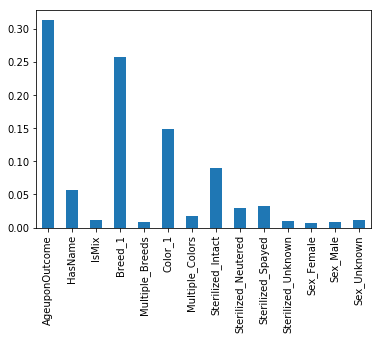

In [27]:
pd.Series(importances_rf, index=features_names).plot(kind='bar')

In [28]:
# Simple XGBClassifier. 
# For better results we need to fine tune the parameters

xgboost = XGBClassifier(learning_rate =0.05,
 n_estimators=500,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softprob',
 nthread=4,
 scale_pos_weight=1,
 seed=27).fit(X_train, y_train)

print('Cross Validation for XGBClassifier')
print(xgboost.score(X_test, y_test))

prediction = pd.DataFrame(xgboost.predict_proba(test_x.values))
prediction.columns = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']
prediction = pd.concat([test['ID'], prediction], axis=1)

prediction.to_csv('xgbclassifier_submit.csv', index=False)

prediction.tail()

Cross Validation for XGBClassifier
0.647961092406


,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
11451,11452,0.860324,0.001622,0.004356,0.011828,0.121870
11452,11453,0.000494,0.035179,0.012993,0.001279,0.950055
11453,11454,0.003188,0.007362,0.096590,0.004165,0.888696
11454,11455,0.324828,0.000417,0.047788,0.493003,0.133964
11455,11456,0.016110,0.000854,0.108580,0.448603,0.425854


In [29]:
importances_xgb = xgboost.feature_importances_
importances_xgb

array([ 0.25379786,  0.03834987,  0.03325231,  0.28958207,  0.02756397,
        0.17959625,  0.04623253,  0.03357302,  0.02255081,  0.02180812,
        0.01296334,  0.02339477,  0.01492134,  0.00241375], dtype=float32)

In [30]:
%matplotlib inline

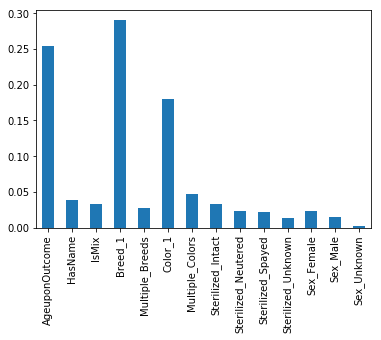

In [31]:
pd.Series(importances_xgb, index=features_names).plot(kind='bar')

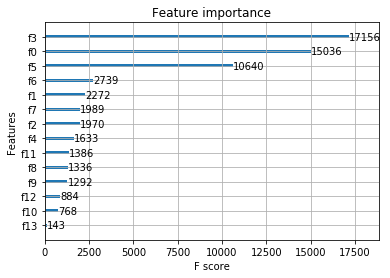

In [32]:
xgb.plot_importance(xgboost)

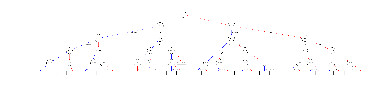

In [33]:
xgb.plot_tree(xgboost, num_trees=2)

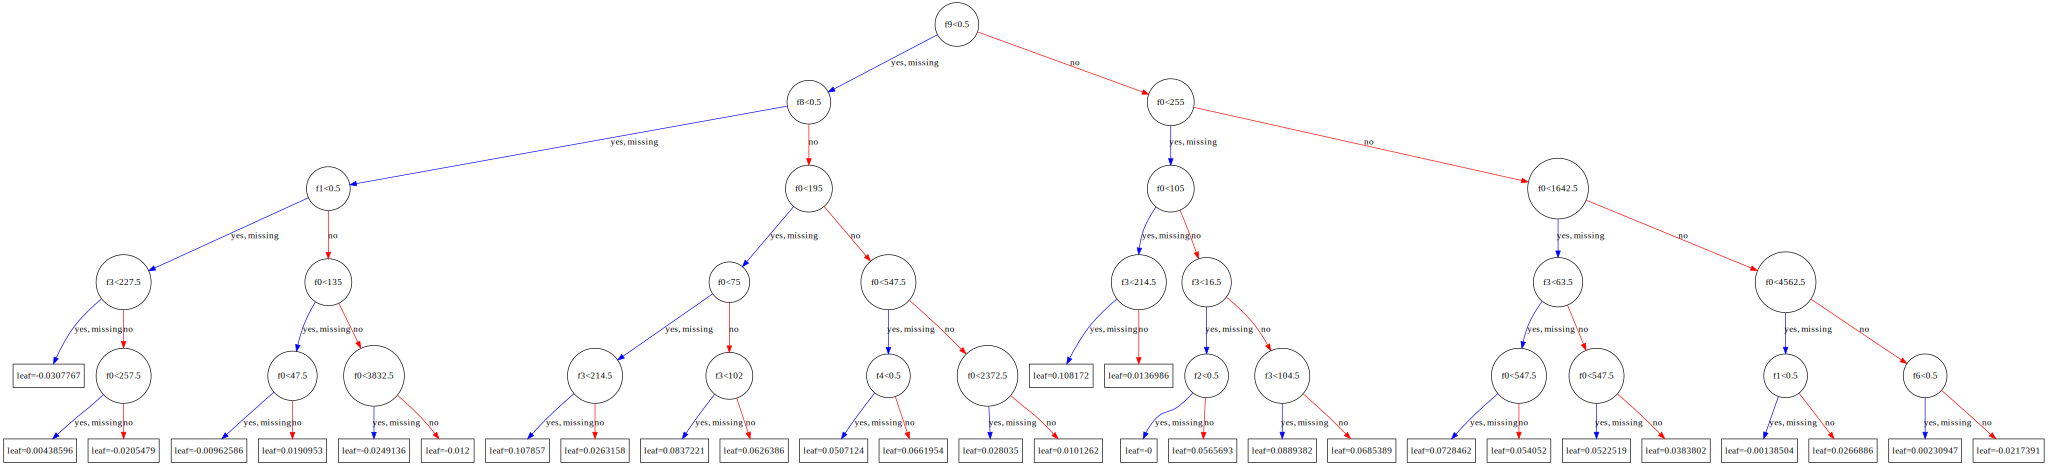

In [34]:
xgb.to_graphviz(xgboost, num_trees=0)